In [36]:
import os
import matplotlib.pyplot as plt
import numpy as np

from contagion.utils import results_from_experiment, available_results
from directories import contagion_figures_dir

%matplotlib inline


# Simplagion Contagion Model of order 2

## Rho over time

In [37]:
_, contagion_experiments = available_results()
experiments = [ex for ex in contagion_experiments if '_ex' in ex]
print('Available experiments:\n\t' + '\n\t'.join(experiments))

Available experiments:
	InVS15_ex1 - lambda_slices
	InVS15_ex2 - lambda_slices
	InVS15_ex3 - lambda_slices
	N212_k24.425_kdelta6.920_ex1 - lambda_slices
	N212_k24.425_kdelta6.920_ex2 - lambda_slices
	N212_k24.425_kdelta6.920_ex3 - lambda_slices
	N500_k20.000_kdelta6.000_ex1 - lambda_slices
	N500_k20.000_kdelta6.000_ex2 - lambda_slices
	N500_k20.000_kdelta6.000_ex3 - lambda_slices


In [38]:
experiment = 'N212_k24.425_kdelta6.920_ex3 - lambda_slices'
version = 2 # either 0 (old), 1 or 2 (with stationary sigma)

results, database = results_from_experiment(experiment, version)
rhos, stationary_rhos, k, k_delta, lambdas, sigma, sigma_delta, rho0s_per_lambda_delta, mu = results

lambda1 = lambdas[0]
lambda_delta = list(rho0s_per_lambda_delta.keys())[0]

beta = 1.*(mu / k) * lambda1
beta_delta = 1.*(mu / k) * lambda_delta

rho0s = rho0s_per_lambda_delta[lambda_delta]

no_iterations = len(rhos[lambda_delta][rho0s[0]][lambda1])
iteration_timesteps = len(rhos[lambda_delta][rho0s[0]][lambda1][0])

print(f'mu: {mu:.2f}')
print(f'beta: {beta:.2f}')
print(f'sigma: {sigma:.2f}')
print(f'beta_delta: {beta_delta:.2f}')
print(f'sigma_delta: {sigma_delta:.2f}')
print('rho0s: ' + str(rho0s))
print(f'no_iterations: {no_iterations}')
print(f'iteration timesteps: {iteration_timesteps}')


mu: 0.70
beta: 0.80
sigma: 0.20
beta_delta: 0.80
sigma_delta: 0.20
rho0s: [0.2, 0.8]
no_iterations: 10
iteration timesteps: 2000


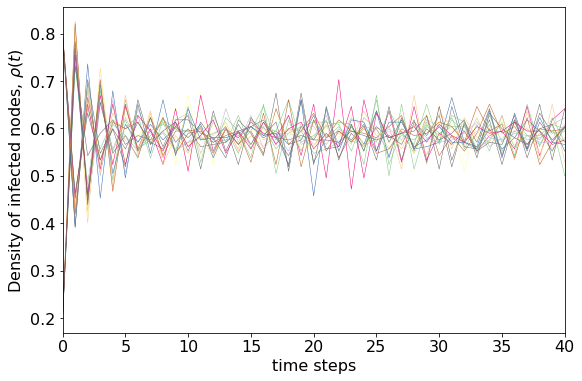

In [39]:
markers = ['D', 's', 'o', '.']
zorders = [8, 7, 6, 5]
mfcs = ['white', 'white', 'white', 'cornflowerblue']
markersizes = [7.5, 7.5, 7, 6]
colormap = plt.cm.get_cmap('Accent')
colors = list(colormap(np.linspace(0, 1, no_iterations)))

fig = plt.figure(figsize=(9, 6))
ax = plt.subplot(111)

x_axis = [timestep for timestep in range(0, iteration_timesteps)]

for rho0 in rho0s:
    for i, iteration in enumerate(rhos[lambda_delta][rho0][lambda1]):
        ax.plot(x_axis, iteration, color=colors[i], ls='-', lw=.5)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(r'time steps', size=16)
ax.set_ylabel(r'Density of infected nodes, $\rho(t)$', size=16)

ax.set_xlim(0, 40)
# ax.legend(loc='best', fontsize=16)

figures_dir = os.path.join(contagion_figures_dir, database)
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
fig.savefig(os.path.join(figures_dir, f'{experiment}.pdf'))
